In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
!pip install torchtuples
!pip install pycox
!pip install eli5

import pandas as pd
import numpy as np
import torchtuples as tt
from sklearn.model_selection import train_test_split
from pycox.models import DeepHitSingle
import torch
from eli5.permutation_importance import get_score_importances

# Load the data
train_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/train_data_lasso_new2.csv")
test_data_lasso = pd.read_csv("/content/drive/MyDrive/thesis data/test_data_lasso_new2.csv")


# Add column with time
train_data_lasso["timeinput"] = train_data_lasso["time"]
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2010,0)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2011,1)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2013,2)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2014,3)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2015,4)
train_data_lasso["timeinput"] = train_data_lasso["timeinput"].replace(2017,5)



test_data_lasso["timeinput"] = test_data_lasso["time"]
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2010,0)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2011,1)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2013,2)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2014,3)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2015,4)
test_data_lasso["timeinput"] = test_data_lasso["timeinput"].replace(2017,5)

# Split the data into train and validation 
df_train = train_data_lasso
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

y_train = (np.array(df_train["timeinput"]), np.array(df_train["status"].astype("float32")))
y_val = (np.array(df_val["timeinput"]), np.array(df_val["status"].astype("float32")))
y_test = (np.array(test_data_lasso["timeinput"]), np.array(test_data_lasso["status"].astype("float32")))

# Create train and validation data tuples
x_train = df_train.drop(['time', 'status', 'timeinput'], axis=1).values
x_val = df_val.drop(['time', 'status', 'timeinput'], axis=1).values
x_train=np.float32(x_train[:][:])
x_val=np.float32(x_val[:][:])

train = (x_train, y_train)
val = (x_val, y_val)


# Create the DeepHit model
in_features = x_train[0].shape[0]
out_features = 6
num_nodes = [128]
batch_norm = True

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm)

optimizer = tt.optim.AdamWR()
model = DeepHitSingle(net, optimizer, duration_index=np.array([2010, 2011, 2013, 2014, 2015, 2017]))

# Train the model
model.optimizer.set_lr(0.01)
epochs = 1000
batch_size = 256
callbacks = [tt.cb.EarlyStoppingCycle()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose = False)


# Evaluate the model on test data
x_test = test_data_lasso.drop(['time', 'status', 'timeinput'], axis=1).values
x_test=np.float32(x_test[:][:])

surv = model.predict_surv_df(x_test)
surv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,0,1,2,3,4,5,6,7,8,9,...,889,890,891,892,893,894,895,896,897,898
2010,0.977446,0.953872,0.964967,0.890800,0.971809,0.905662,0.929959,0.972327,0.947351,0.975163,...,0.937685,0.967625,0.945864,0.948158,0.977214,0.981739,0.914497,0.965726,0.981322,0.979627
2011,0.950259,0.926802,0.939106,0.828057,0.945445,0.861220,0.880619,0.943831,0.901291,0.947136,...,0.900258,0.937741,0.904333,0.908942,0.951814,0.961912,0.850153,0.937852,0.953233,0.956148
2013,0.921603,0.902152,0.919036,0.821511,0.920643,0.850845,0.869976,0.922492,0.890274,0.922475,...,0.883658,0.913713,0.897443,0.895315,0.923998,0.924829,0.845311,0.914156,0.925669,0.935678
2014,0.915864,0.895177,0.912056,0.810954,0.914511,0.840821,0.861233,0.916126,0.881660,0.916230,...,0.875716,0.907159,0.872062,0.887232,0.918517,0.919501,0.817158,0.907260,0.920274,0.919622
2015,0.912279,0.891616,0.908138,0.807348,0.910665,0.837002,0.857579,0.912320,0.877820,0.912405,...,0.872105,0.903373,0.869069,0.883173,0.914757,0.915862,0.814247,0.903388,0.916570,0.916881
2017,0.904871,0.884152,0.900045,0.796747,0.902933,0.826630,0.847531,0.904186,0.867606,0.904305,...,0.863745,0.895335,0.846071,0.873183,0.907294,0.908900,0.789364,0.895255,0.908872,0.899755


In [4]:

surv.to_csv('/content/drive/MyDrive/surv_new_test_0.797.csv', index=False)

In [26]:
from pycox.evaluation.concordance import concordance_td
from pycox.evaluation import EvalSurv
from sklearn.metrics import brier_score_loss

ev = EvalSurv(surv, *y_test) # surv
c_index = ev.concordance_td('antolini')

print("C_INDEX python  :", c_index)

# Define scoring function for permutation importance (C-index)
def score(X, Y):
    surv = surv = model.predict_surv_df(X)
    ev = EvalSurv(surv, *Y)
    c_index = ev.concordance_td('antolini')
    return c_index

# Calculate feature importances
base_score, score_decreases = get_score_importances(score, x_test, y_test)
feature_importances = np.mean(score_decreases, axis=0)

# Put feature importances in Pandas dataframe
pd.DataFrame(feature_importances, index = test_data_lasso.drop(['time', 'status', 'timeinput'], axis=1).columns)

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


C_INDEX!!!!  : 0.7965042536736272


/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/usr/local/lib/python3.10/di

,0
pppadate_yrmo,0.001856
how_long_relationship,0.020609
ppeduc.13,0.001865
ppethm.2,-0.001836
ppmarit.4,-0.000940
ppmarit.5,-0.000195
ppreg9.4,-0.000269
ppreg9.5,-0.000667
papglb_friend.4,0.001063
pphhcomp11_member2_relationship.2,0.030405


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

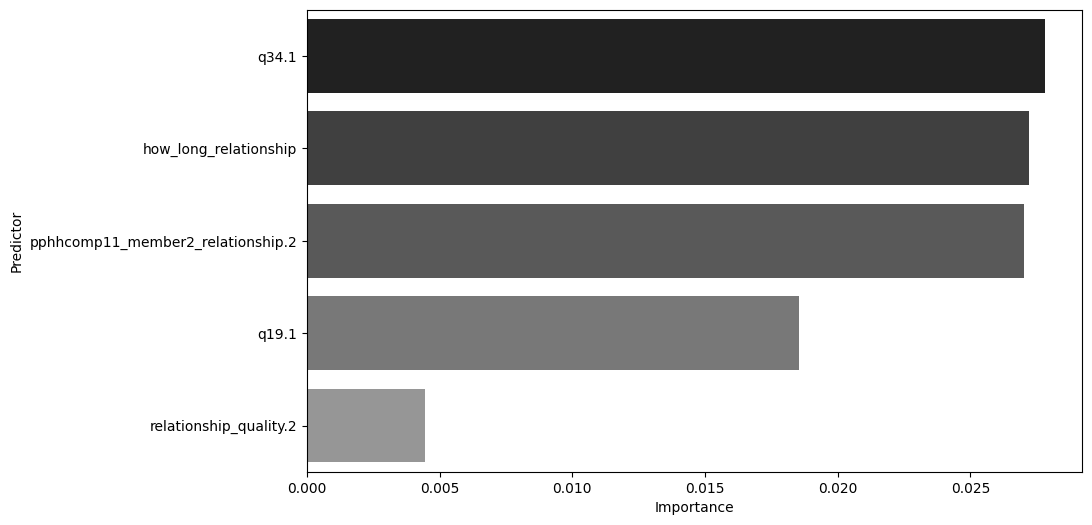

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files


feature_importances_df = pd.DataFrame(feature_importances, index=test_data_lasso.drop(['time', 'status', 'timeinput'], axis=1).columns, columns=['Importance'])
# Sort the DataFrame by importance 
top_5_features = feature_importances_df.abs().nlargest(5, 'Importance')

# Define a custom color palette with shades of grey
colors = ['#212121', '#404040', '#595959', '#787878', '#969696']

# Create a bar plot using seaborn with the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_features['Importance'], y=top_5_features.index, palette=colors)
plt.xlabel('Importance')
plt.ylabel('Predictor')

# Save the figure to Google Drive
plt.savefig("feature importance.png")
files.download("feature importance.png")

plt.show()
